In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model

2024-06-03 16:16:51.181979: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/johnbjohn/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-06-03 16:16:52.398028: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-06-03 16:16:52.405551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 16:16:52.405730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.535GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2024-06-03 16:16:52.405747: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-06-03 16:16:52.408788: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-06-03 16:16:52.408846: I tensorflow/stream_executor/p

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'tf_flowers', 
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)

IMG_HEIGHT, IMG_WIDTH = 224, 224

def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image, label

ds_train = ds_train.map(resize_and_rescale)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(resize_and_rescale)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

2024-06-03 16:16:52.431121: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 16:16:52.432454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 16:16:52.432713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.535GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2024-06-03 16:16:52.432794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1

In [7]:
pretrained_model = tf.keras.applications.MobileNetV2(
    weights = 'imagenet',
    include_top = False,
    input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]
)

pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax()
])

# build, compile, and print out the model summary
model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 3))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
_________________________________________________________________
softmax (Softmax)            (None, 5)                 0         
Total params: 2,587,205
Trainable params: 329,221
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10,
    verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
23/23 - 3s - loss: 0.7748 - accuracy: 0.6996 - val_loss: 0.4032 - val_accuracy: 0.8583
Epoch 2/10
23/23 - 1s - loss: 0.3233 - accuracy: 0.8879 - val_loss: 0.3327 - val_accuracy: 0.8951
Epoch 3/10
23/23 - 1s - loss: 0.2210 - accuracy: 0.9319 - val_loss: 0.2954 - val_accuracy: 0.9142
Epoch 4/10
23/23 - 1s - loss: 0.1609 - accuracy: 0.9516 - val_loss: 0.2798 - val_accuracy: 0.9114
Epoch 5/10
23/23 - 1s - loss: 0.1203 - accuracy: 0.9704 - val_loss: 0.2940 - val_accuracy: 0.8992
Epoch 6/10
23/23 - 1s - loss: 0.0836 - accuracy: 0.9843 - val_loss: 0.2799 - val_accuracy: 0.9087
Epoch 7/10
23/23 - 1s - loss: 0.0608 - accuracy: 0.9932 - val_loss: 0.2768 - val_accuracy: 0.9074
Epoch 8/10
23/23 - 1s - loss: 0.0458 - accuracy: 0.9942 - val_loss: 0.2707 - val_accuracy: 0.9169
Epoch 9/10
23/23 - 1s - loss: 0.0348 - accuracy: 0.9973 - val_loss: 0.2839 - val_accuracy: 0.9101
Epoch 10/10
23/23 - 1s - loss: 0.0279 - accuracy: 0.9980 - val_loss: 0.2885 - val_accuracy: 0.9128


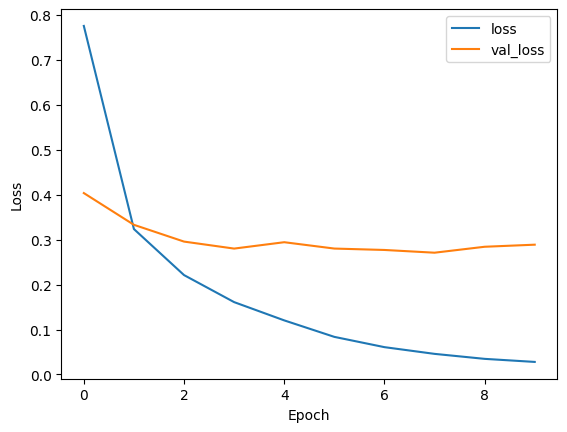

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

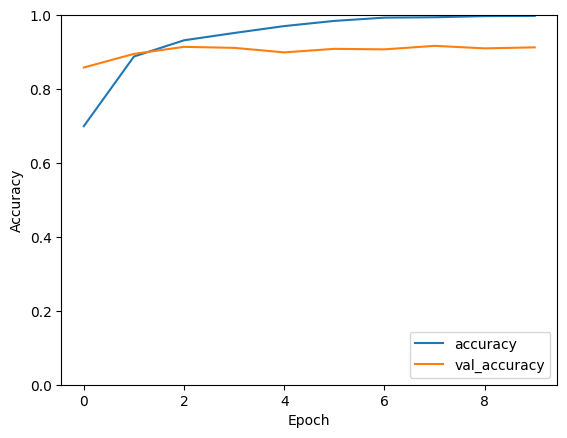

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [11]:
# get the precision and recall
from sklearn.metrics import classification_report

y_pred = model.predict(ds_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in ds_test], axis=0)
target_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       daisy       0.91      0.96      0.94       159
   dandelion       0.95      0.91      0.93       120
       roses       0.93      0.88      0.90       186
  sunflowers       0.90      0.90      0.90       138
      tulips       0.88      0.92      0.90       131

    accuracy                           0.91       734
   macro avg       0.91      0.91      0.91       734
weighted avg       0.91      0.91      0.91       734



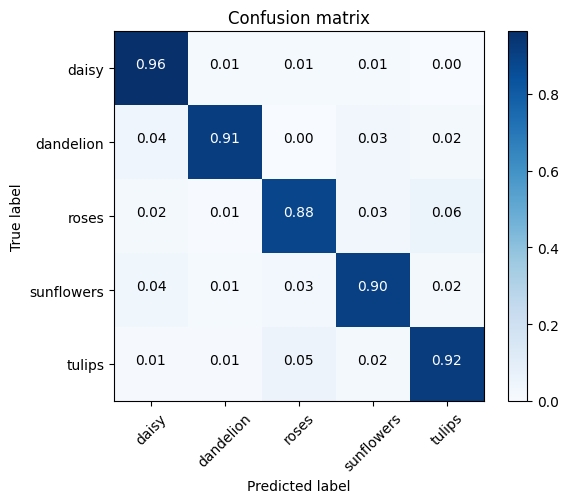

In [14]:
# graph the confusion matrix without seaborn
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, class_names):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, target_names)
